In [1]:
import numpy as np
import pandas as pd
from astropy.cosmology import Planck13 as cosmo
from astropy.io import fits
from astropy.table import Table
import fsps
from matplotlib.gridspec import GridSpec
from spec_tools import Smooth,Scale_model, Oldest_galaxy, Sig_int,Likelihood_contours, Median_w_Error_cont
from spec_exam import Gen_spec
from sim_engine import F_lam_per_M
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from C_full_fit import Gen_spec2, Chi_Squared,Calzetti
from dynesty.utils import quantile as _quantile
from scipy.ndimage import gaussian_filter as norm_kde

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 


# Create 2-component galaxy

### 1) model 2D noise

In [2]:
def Trace_mask(beam, r):
    dy0 = 0
    modelf = np.zeros(np.product(beam.beam.sh_beam), dtype=np.float)
    model = modelf.reshape(beam.beam.sh_beam)
    dy = np.cast[int](np.round(beam.beam.ytrace+dy0))
    aper = np.zeros_like(model)
    y0 = beam.beam.sh_beam[0] // 2
    for d in range(-r, r+1):
        for i in range(beam.beam.sh_beam[1]):
            aper[y0+d+dy[i]-1,i] = 1

    masked_beam = np.zeros_like(beam.beam.model)

    for i in range(len(masked_beam)):
        for ii in range(len(masked_beam.T)):
            if aper[i][ii] == 1:
                masked_beam[i][ii] = beam.grism.data['SCI'][i][ii] - beam.contam[i][ii]
        
    return masked_beam

def Noise_mask(beam, r):
    dy0 = 0
    modelf = np.zeros(np.product(beam.beam.sh_beam), dtype=np.float)
    model = modelf.reshape(beam.beam.sh_beam)
    dy = np.cast[int](np.round(beam.beam.ytrace+dy0))
    aper = np.zeros_like(model)
    y0 = beam.beam.sh_beam[0] // 2
    for d in range(-r, r+1):
        for i in range(beam.beam.sh_beam[1]):
            aper[y0+d+dy[i]-1,i] = 1

    masked_beam = np.zeros_like(beam.beam.model)

    for i in range(len(masked_beam)):
        for ii in range(len(masked_beam.T)):
            if aper[i][ii] == 0:
                masked_beam[i][ii] = beam.grism.data['SCI'][i][ii] - beam.contam[i][ii]
        
    return masked_beam

def Get_noise_dist(noise):
    sample = noise
    
    weight = np.ones_like(noise)

    q = [0.5 - 0.5 * 0.999999426697, 0.5 + 0.5 * 0.999999426697]
    span = _quantile(sample.T, q, weights=weight)

    s = 0.02

    bins = int(round(10. / 0.02))
    n, b = np.histogram(sample, bins=bins, weights=weight,
                        range=np.sort(span))
    n = norm_kde(n, 10.)
    x0 = 0.5 * (b[1:] + b[:-1])
    y0 = n
    
    return x0, y0 / np.trapz(y0,x0)

In [41]:
sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 4, tau=0.5, dust_type = 1)
Owave, Oflux = sp.get_spectrum(tage=2, peraa=True)
Oflam = F_lam_per_M(Oflux, Owave*(1+1.25),1.25,0, sp.stellar_mass)
Iwave, Iflux = sp.get_spectrum(tage=4, peraa=True)
Iflam = F_lam_per_M(Iflux, Iwave*(1+1.25),1.25,0, sp.stellar_mass)


In [118]:
Obeam = model.BeamCutout(fits_file=glob('../CLEAR_show_and_tell/*_12078.g102.A.fits')[3])
Ibeam = model.BeamCutout(fits_file=glob('../CLEAR_show_and_tell/*_12078.g102.A.fits')[3])

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


In [5]:
nObeam = Noise_mask(Obeam,3)
nIbeam = Noise_mask(Ibeam,4)

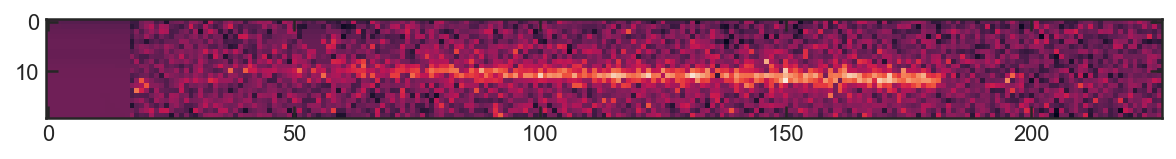

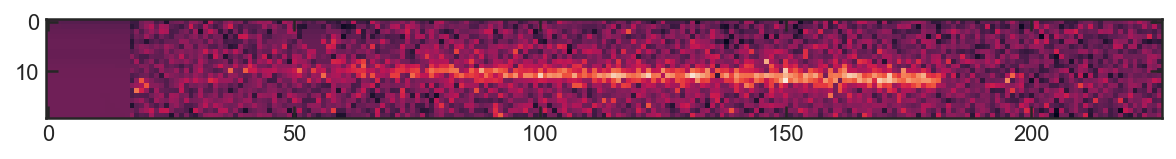

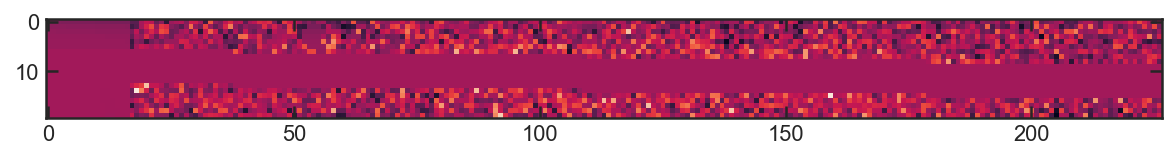

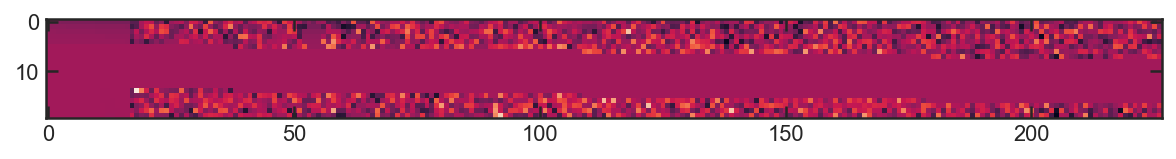

In [6]:
plt.figure(figsize=[10,5])
plt.imshow(Obeam.grism.data['SCI'] - Obeam.contam)
plt.figure(figsize=[10,5])
plt.imshow(Ibeam.grism.data['SCI'] - Ibeam.contam)
plt.figure(figsize=[10,5])
plt.imshow(nObeam)
plt.figure(figsize=[10,5])
plt.imshow(nIbeam)

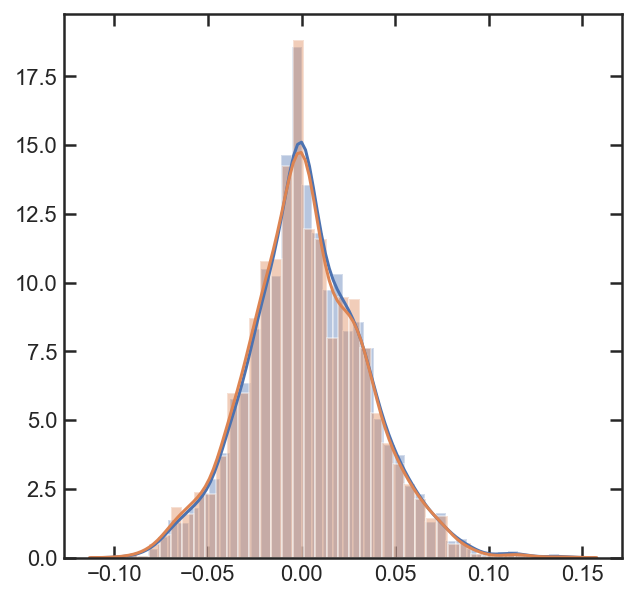

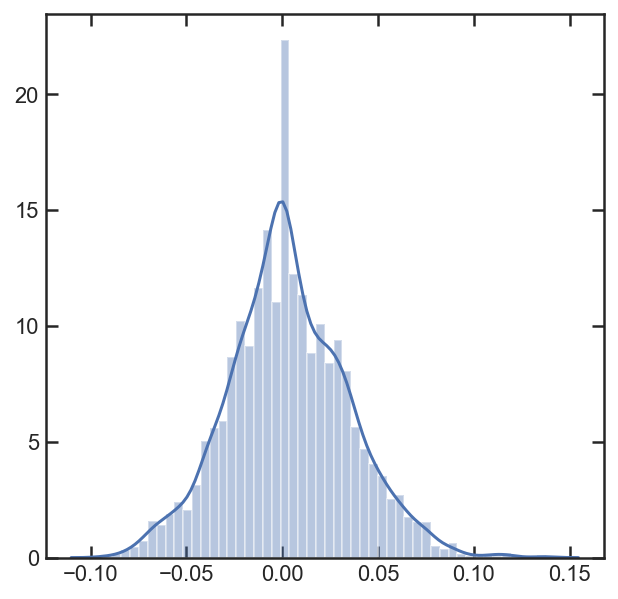

In [7]:
plt.figure(figsize=[5,5])
sea.distplot((nObeam[nObeam!=0]).ravel())
sea.distplot((nIbeam[nIbeam!=0]).ravel())

plt.figure(figsize=[5,5])
sea.distplot(np.append((nIbeam[nIbeam!=0]).ravel() , (nObeam[nObeam!=0]).ravel()))

In [8]:
fnoise = np.append((nIbeam[nIbeam!=0]).ravel() , (nObeam[nObeam!=0]).ravel())
nvals, ndist = Get_noise_dist(fnoise)

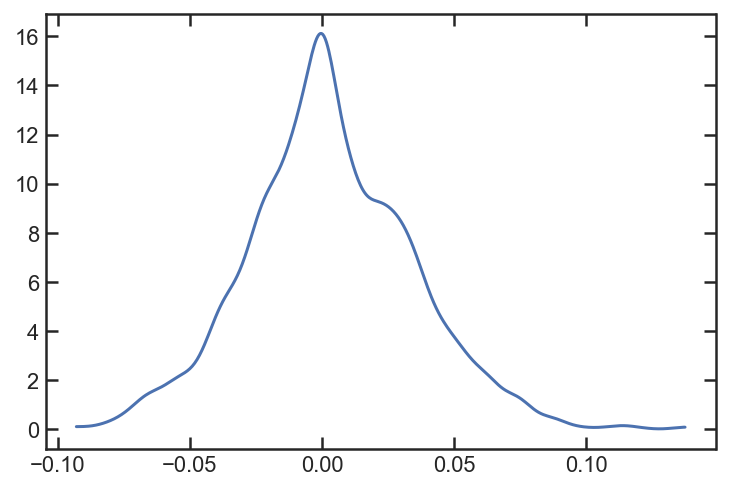

In [9]:
plt.plot(nvals,ndist)

### 2) create profiles

In [13]:
from spec_tools import Gauss_dist
def Gen_2d_gauss(gridsize,mu,sig):
    grid_range = np.arange(gridsize)
    g=Gauss_dist(grid_range,mu,sig)
    grid = np.ones([gridsize,gridsize])

    for i in range(len(grid)):
        grid[i] *= g

    for i in range(len(grid)):
        grid.T[i] *= g

    return np.array(grid).astype(np.float32)

In [14]:
R = np.linspace(0,20,1000)
ISp = Gauss_dist(R, 10, 0.5)
OSp = Gauss_dist(R, 10, 2)

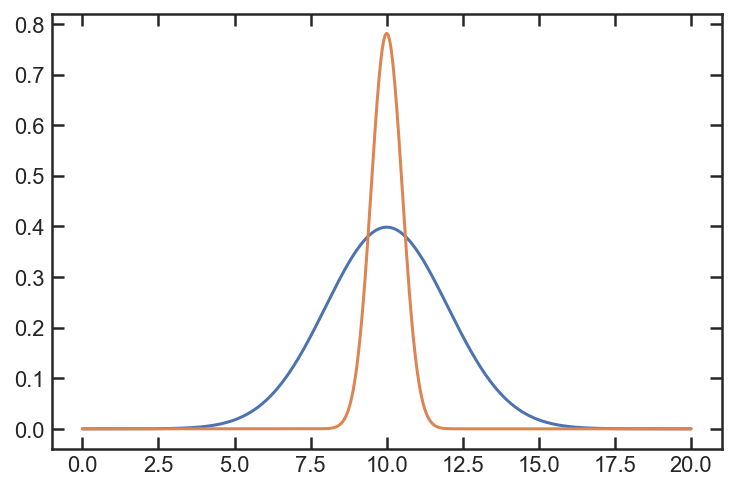

In [15]:
# plt.plot(fR,fSp)
plt.plot(R,Smooth(OSp,R,0.1)*2)
plt.plot(R,Smooth(ISp,R,0.1))


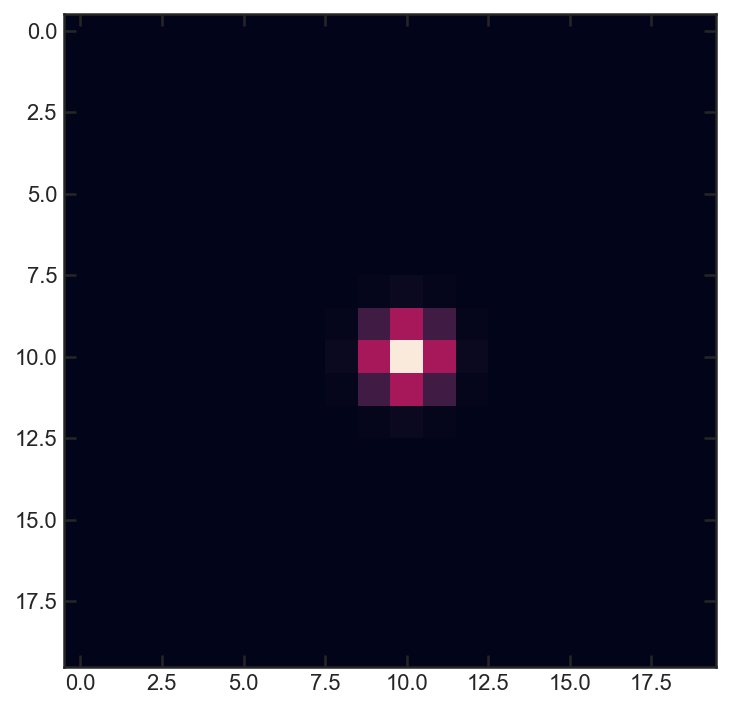

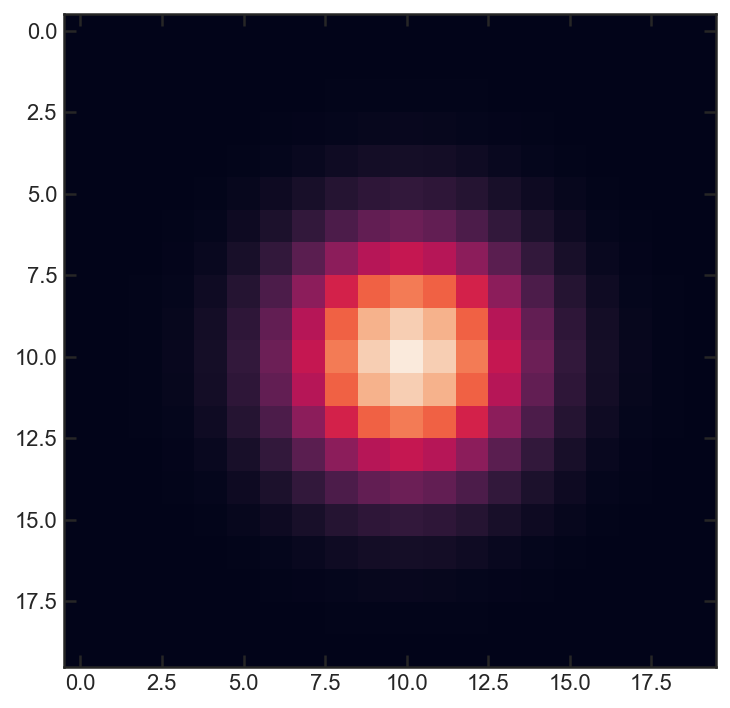

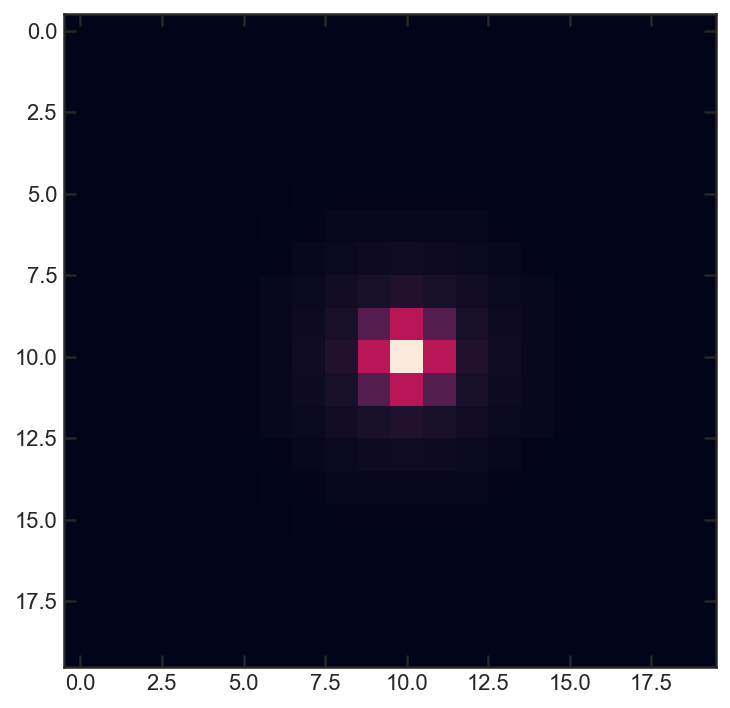

In [121]:
Iimg = Gen_2d_gauss(20,10,0.75)
Oimg = Gen_2d_gauss(20,10,2.5)

Obeam.beam.direct = Oimg*2
Ibeam.beam.direct = Iimg
    
plt.figure(figsize=[6,6])
plt.imshow(Iimg)

plt.figure(figsize=[6,6])
plt.imshow(Oimg)

plt.figure(figsize=[6,6])
plt.imshow(Oimg + Iimg)

### 3) Gen ind beams

In [119]:
flat = Obeam.flat_flam.reshape(Obeam.beam.sh_beam)
w, ffl, e = Obeam.beam.trace_extract(flat, ivar=Obeam.ivar, r=7)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:656: RuntimeWarning: divide by zero encountered in true_divide
  var = 1./ivar


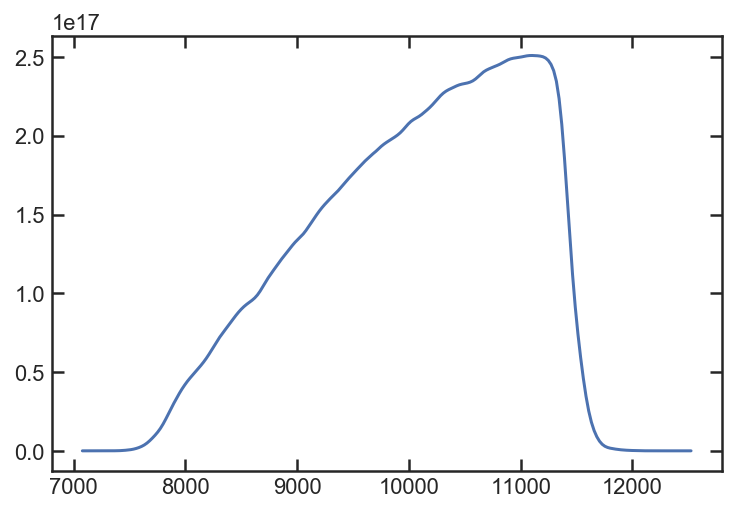

In [120]:
plt.plot(w,ffl)

In [24]:
ivar = np.array(Obeam.ivar)

In [122]:
Obeam.beam.compute_model(spectrum_1d=[Owave * (1+1.25),Oflam*10**10.8])
Ibeam.beam.compute_model(spectrum_1d=[Iwave * (1+1.25),Iflam*10**11.3])

True

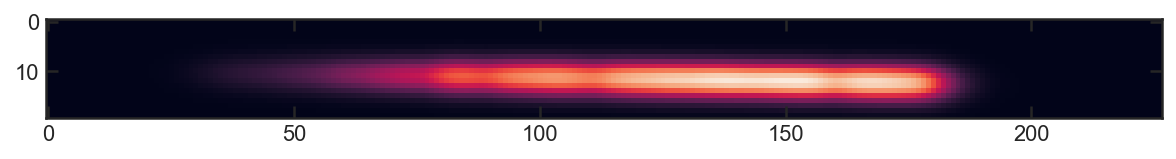

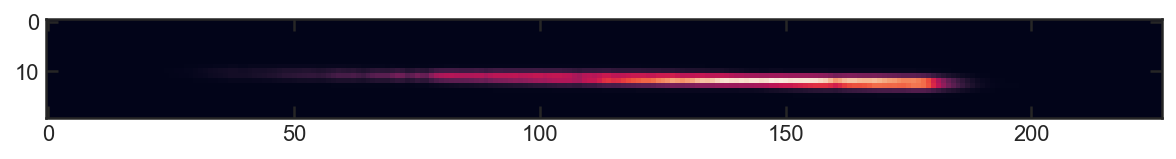

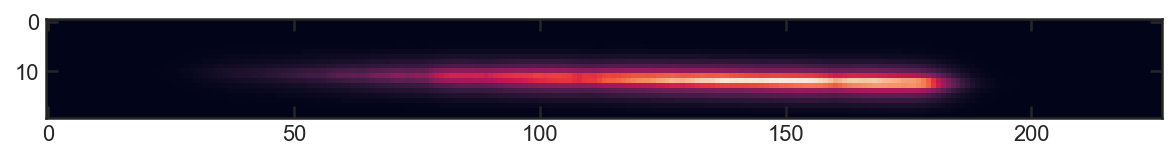

In [123]:
plt.figure(figsize=[10,5])
plt.imshow(Obeam.beam.model)

plt.figure(figsize=[10,5])
plt.imshow(Ibeam.beam.model)

plt.figure(figsize=[10,5])
plt.imshow(Ibeam.beam.model + Obeam.beam.model)

In [124]:
Owm,Ofm,Oe = Obeam.beam.trace_extract(Obeam.beam.model, bin=0, r = 7)
Iwm,Ifm,Ie = Ibeam.beam.trace_extract(Ibeam.beam.model, bin=0, r = 7)
Cwm,Cfm,Ce = Ibeam.beam.trace_extract(Ibeam.beam.model + Obeam.beam.model, bin=0, r = 7)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


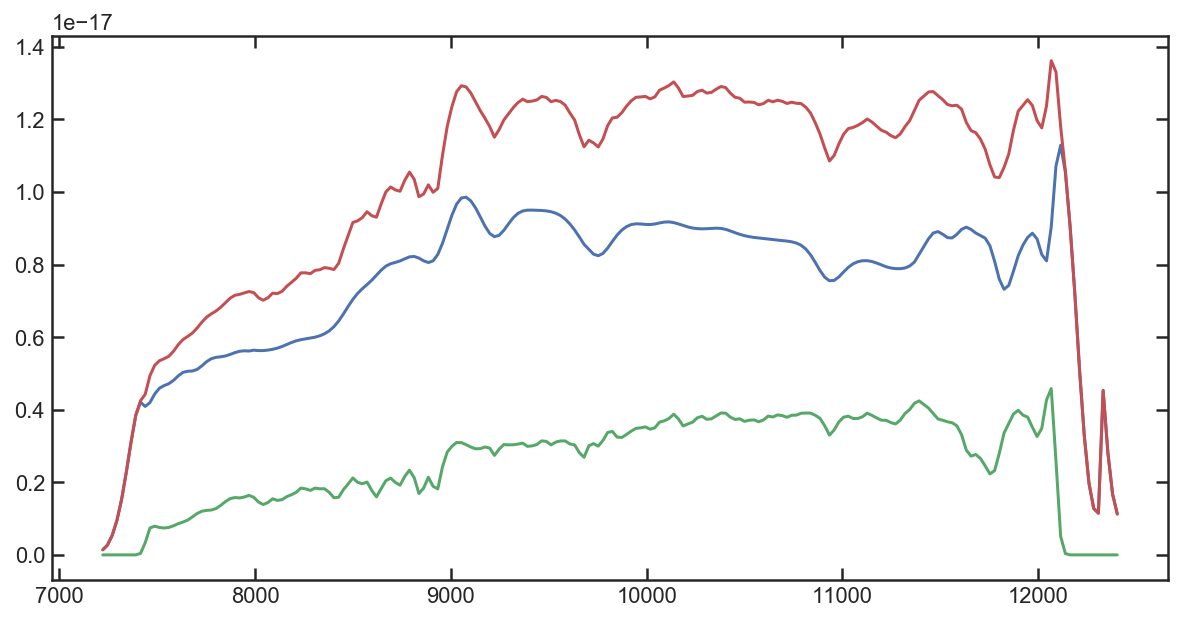

In [125]:
plt.figure(figsize=[10,5])
plt.plot(Owm,Ofm/ffl , 'b')

# plt.figure(figsize=[10,5])
plt.plot(Iwm,Ifm/ffl ,'g')

# plt.figure(figsize=[10,5])
plt.plot(Cwm,Cfm/ffl,'r')

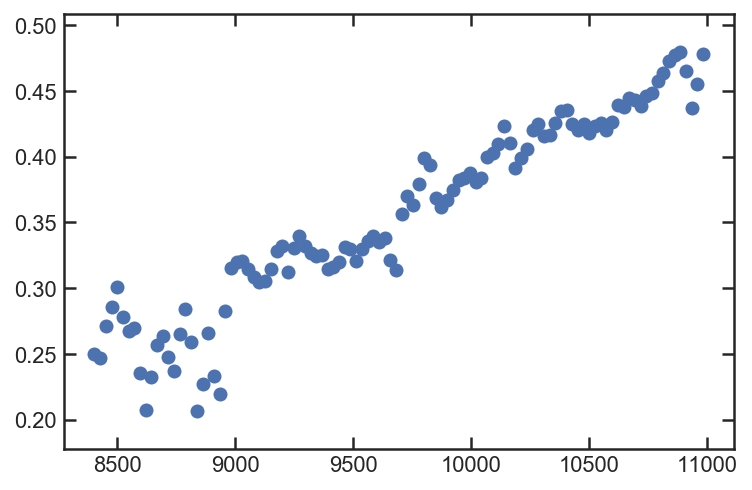

In [126]:
IDW = [U for U in range(len(Iwm)) if 8400 < Iwm[U] < 11000]

plt.scatter(Iwm[IDW], Ifm[IDW]/Ofm[IDW])

### 4) add noise

In [48]:
def Gen_PPF(x,px):
    return interp1d(np.cumsum(px) / np.cumsum(px).max(),x, fill_value=0, bounds_error=False)

In [49]:
N = Gen_PPF(nvals,ndist)

(20, 227)


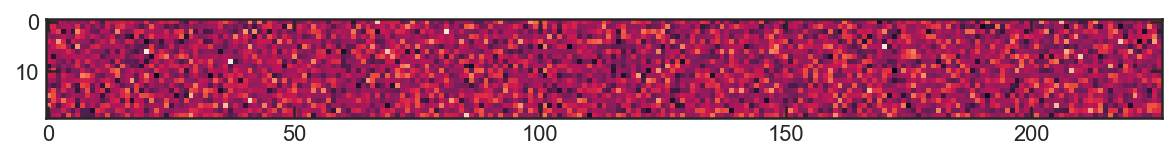

In [50]:
print(Obeam.beam.sh_beam)

bnoise = N(np.random.rand(20, 227))

plt.figure(figsize=[10,5])
plt.imshow(bnoise)

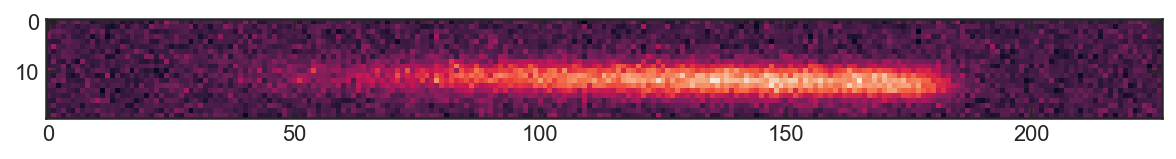

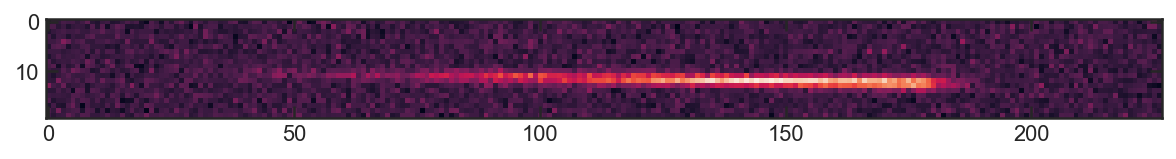

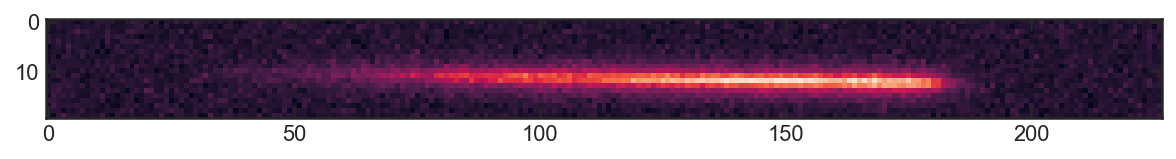

In [127]:
Omodel2d = Obeam.beam.model + N(np.random.rand(20, 227))
Imodel2d = Ibeam.beam.model + N(np.random.rand(20, 227))
Cmodel2d = Obeam.beam.model + Ibeam.beam.model + N(np.random.rand(20, 227))




plt.figure(figsize=[10,5])
plt.imshow(Omodel2d)

plt.figure(figsize=[10,5])
plt.imshow(Imodel2d)

plt.figure(figsize=[10,5])
plt.imshow(Cmodel2d)

In [128]:
Ow,Of,Oe = get_inner_spec_model(Obeam, Omodel2d , rp=7)
Iw,If,Ie = get_inner_spec_model(Ibeam, Imodel2d , rp=7)
Cw,Cf,Ce = get_inner_spec_model(Ibeam, Cmodel2d , rp=7)


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:656: RuntimeWarning: divide by zero encountered in true_divide
  var = 1./ivar


<ErrorbarContainer object of 3 artists>

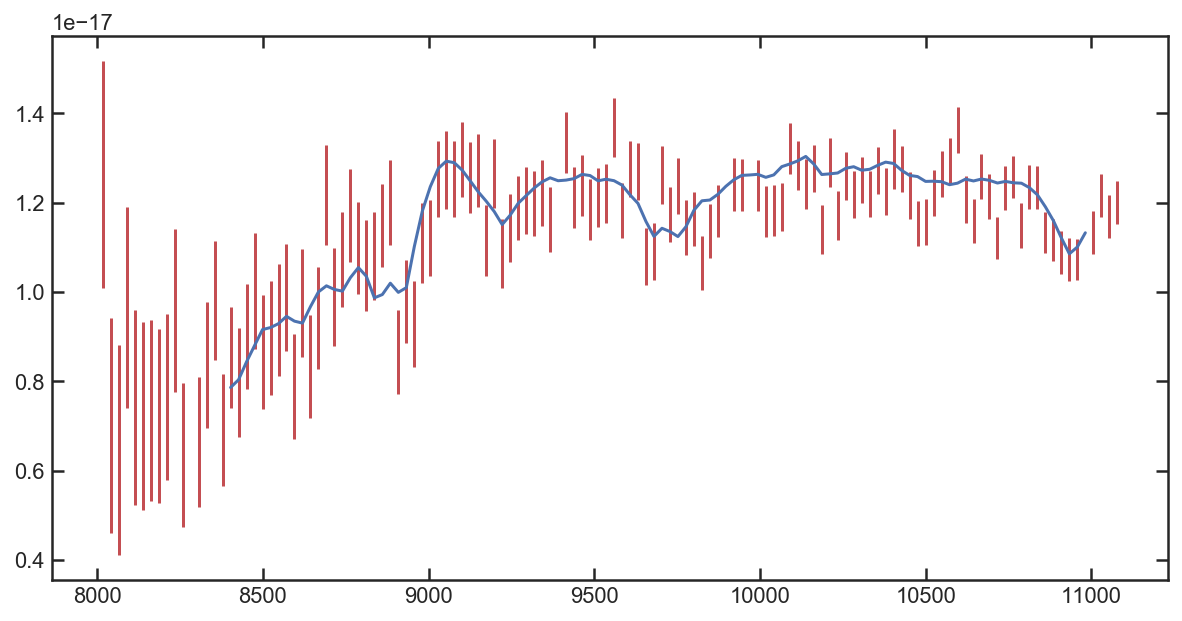

In [129]:
IDX = [U for U in range(len(Ow)) if 8000 < Ow[U] < 11100]

plt.figure(figsize=[10,5])
# plt.errorbar(Ow[IDX],Of[IDX]/ffl[IDX], Oe[IDX] / ffl[IDX] ,color = 'b', linestyle = 'none')
plt.plot(Cwm[IDW], Cfm[IDW]/ffl[IDW])
# # plt.figure(figsize=[10,5])
# plt.errorbar(Iw[IDX],If[IDX]/ffl[IDX], Ie[IDX] / ffl[IDX] ,color ='g', linestyle = 'none')

# # plt.figure(figsize=[10,5])
plt.errorbar(Cw[IDX],Cf[IDX], Ce[IDX],color ='r', linestyle = 'none')

In [56]:
def Stack(wv, fl , er):
    
    stwv = [0]
    
    for w in wv:
        if len(w) > len(stwv):
            stwv = w
    
    flxgrid = []
    errgrid = []
    
    for i in range(len(fl)):
        ifl = interp1d(wv[i][~np.isnan(fl[i])], fl[i][~np.isnan(fl[i])], bounds_error=False, fill_value=0)
        ier = interp1d(wv[i][~np.isnan(fl[i])], er[i][~np.isnan(fl[i])], bounds_error=False, fill_value=1E5)
        
        flxgrid.append(ifl(stwv))
        errgrid.append(ier(stwv))
    
    flgrid = np.transpose(flxgrid)
    errgrid = np.transpose(errgrid)
    weigrid = errgrid ** (-2)
    infmask = np.isinf(weigrid)
    weigrid[infmask] = 0
    ################

    stack, err = np.zeros([2, len(stwv)])
    for i in range(len(stwv)):
        stack[i] = np.sum(flgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
        
        err[i] = 1 / np.sqrt(np.sum(weigrid[i]))
    ################
    
    return stwv, stack, err

def get_inner_spec_model(beam, spec2d, fflux = ffl, rp =1):
    wave, flux, err = beam.beam.trace_extract(spec2d, r=rp,ivar= ivar)

    ok = beam.beam.sensitivity > 0.1*beam.beam.sensitivity.max()

    wave = wave[ok]
    flux  = (flux/fflux)[ok]*beam.beam.scale
    err   = (err/fflux)[ok]

    okerr = np.isfinite(err)
    
    wave = wave[okerr]
    flux = flux[okerr]
    err = err[okerr]
    
    okerr = err < 2*flux
    
    return wave[okerr], flux[okerr], err[okerr]

In [130]:
IWV, IFL, IER = [[],[],[]]
FWV, FFL, FER = [[],[],[]]

for fitsfile in glob('../CLEAR_show_and_tell/*_12078.g102.A.fits'):
    obeam = model.BeamCutout(fits_file=fitsfile)
    ibeam = model.BeamCutout(fits_file=fitsfile)
    
    obeam.beam.direct = Oimg*2
    ibeam.beam.direct = Iimg
    
    
    obeam.beam.compute_model(spectrum_1d=[Owave * (1+1.25),Oflam*10**10.8])
    ibeam.beam.compute_model(spectrum_1d=[Iwave * (1+1.25),Iflam*10**11.3])
    
    cmodel2d = obeam.beam.model + ibeam.beam.model + N(np.random.rand(20, 227))
    
    Fw,Ff,Fe = get_inner_spec_model(obeam, cmodel2d , rp=7)
    Iw,If,Ie = get_inner_spec_model(obeam, cmodel2d , rp=2)
    
    if len(Iw) > 2:
        IWV.append(Iw)
        IFL.append(If)    
        IER.append(Ie)  
        
        FWV.append(Fw)
        FFL.append(Ff)    
        FER.append(Fe)  

MWV, MFL, MER = Stack(np.array(FWV),np.array(FFL),np.array(FER))
IWV, IFL, IER = Stack(np.array(IWV),np.array(IFL),np.array(IER))

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:656: RuntimeWarning: divide by zero encountered in true_divide
  var = 1./ivar


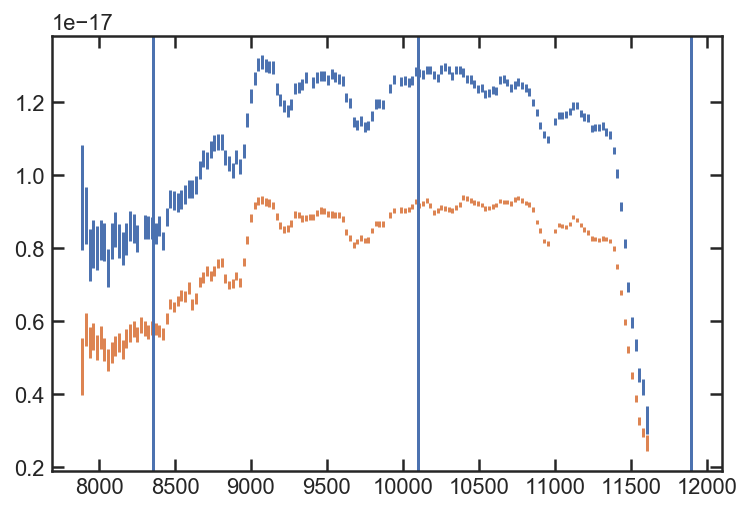

In [131]:
plt.errorbar(MWV, MFL, MER, linestyle = 'none')
plt.errorbar(IWV, IFL, IER, linestyle = 'none')

plt.axvline(8357)
plt.axvline(10101)
plt.axvline(11897)

In [132]:
IDX = [U for U in range(len(MWV)) if 8400 < MWV[U] < 11000]

MWV = MWV[IDX]
MFL = MFL[IDX]
MER = MER[IDX]

iIFL = interp1d(IWV,IFL)(MWV)
iIER = interp1d(IWV,IER)(MWV)

scl = np.trapz(MFL, MWV)
scl2 =np.trapz(iIFL, MWV)

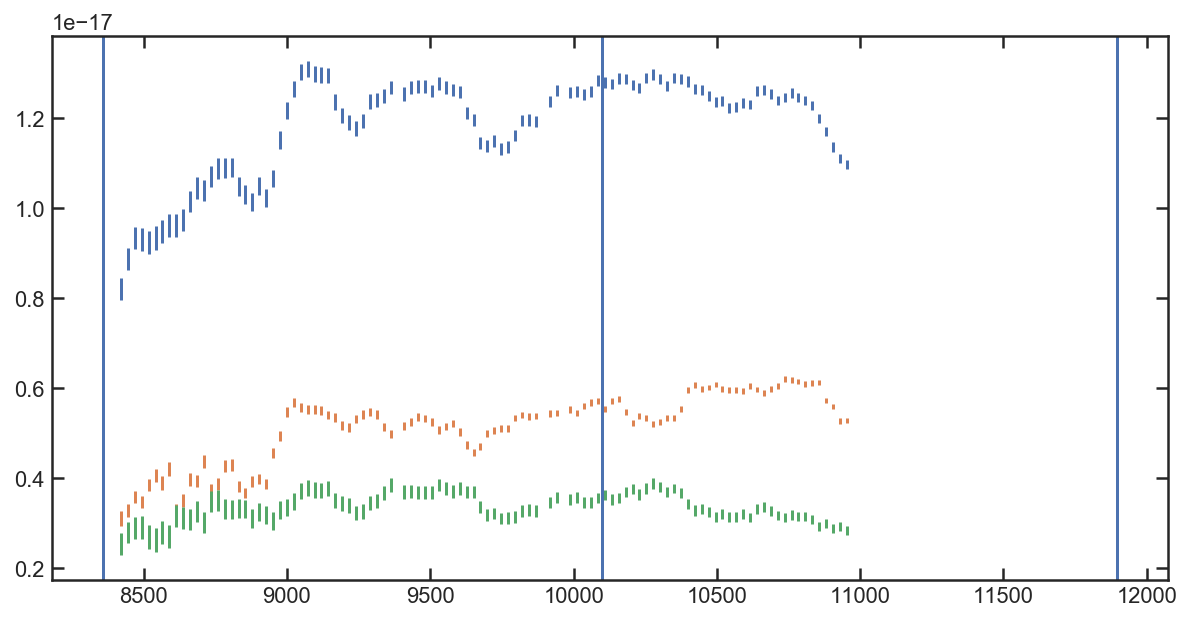

In [133]:
OFL = MFL - iIFL


plt.figure(figsize = [10,5])

plt.errorbar(MWV, MFL, MER, linestyle = 'none')

plt.errorbar(MWV, iIFL - OFL , iIER, linestyle = 'none')
plt.errorbar(MWV, OFL, MER, linestyle = 'none')

plt.axvline(8357)
plt.axvline(10101)
plt.axvline(11897)

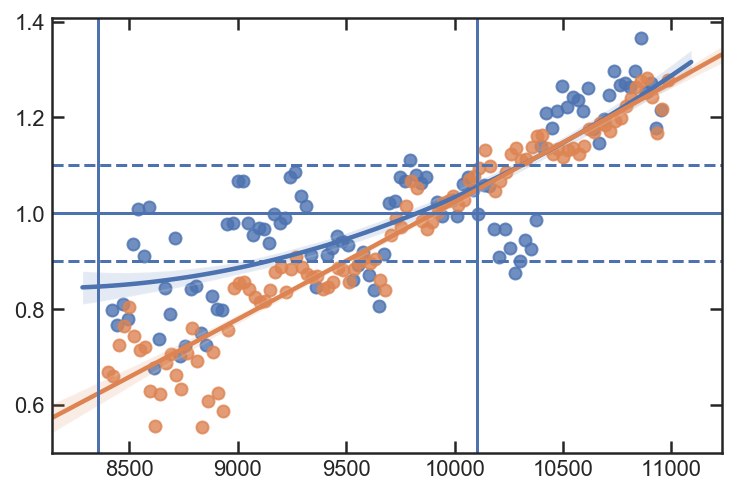

In [134]:
scl = np.trapz(OFL, MWV)
scl2 =np.trapz((iIFL - OFL), MWV)



sea.regplot(MWV, (iIFL - OFL)/(OFL) * scl / scl2, order = 2 , ci=68)


scl = np.trapz(Ofm[IDW], Iwm[IDW])
scl2 =np.trapz(Ifm[IDW], Iwm[IDW])

sea.regplot(Iwm[IDW], Ifm[IDW]/Ofm[IDW]* scl / scl2, order = 2 , ci=68)

plt.axhline(1)
plt.axhline(1.1, linestyle = '--')
plt.axhline(0.9, linestyle = '--')


plt.axvline(8357)
plt.axvline(10101)
# plt.axvline(11897)

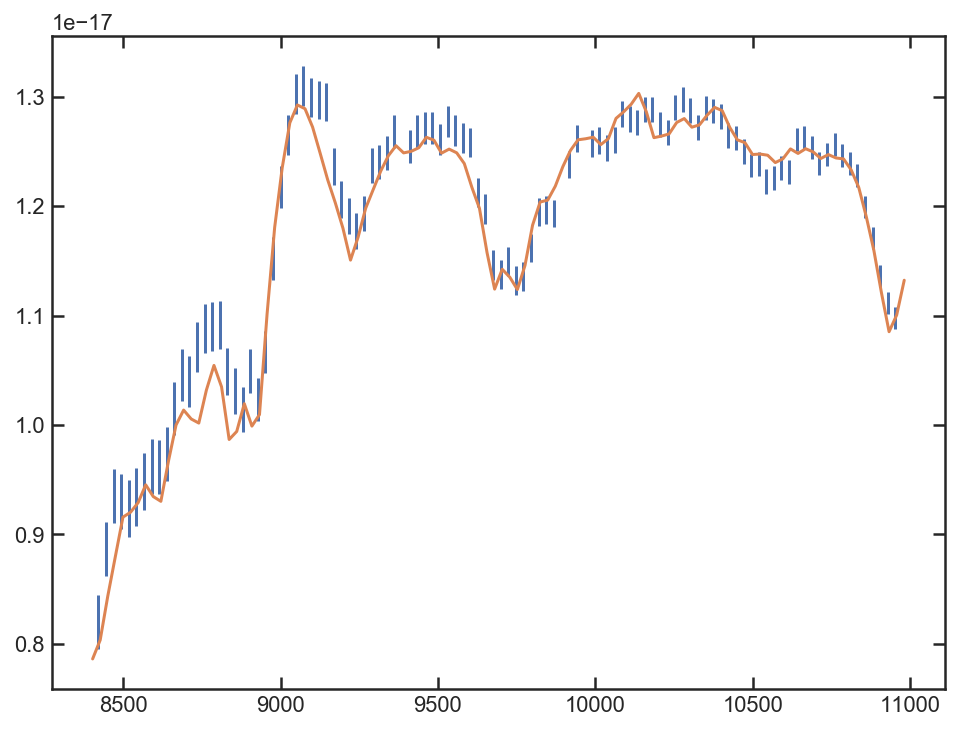

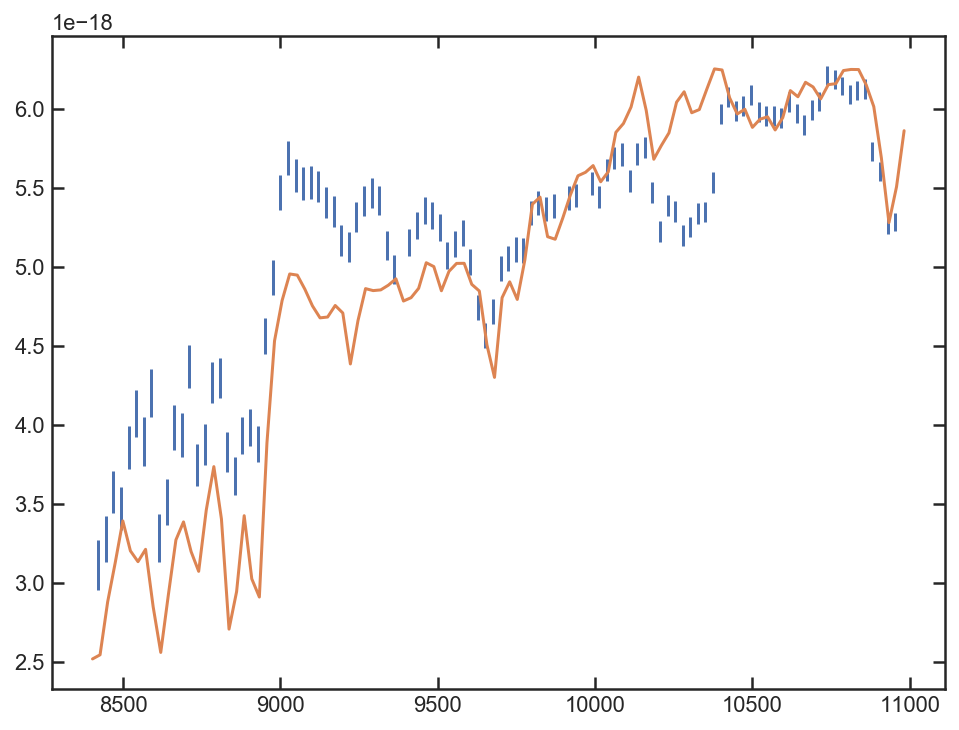

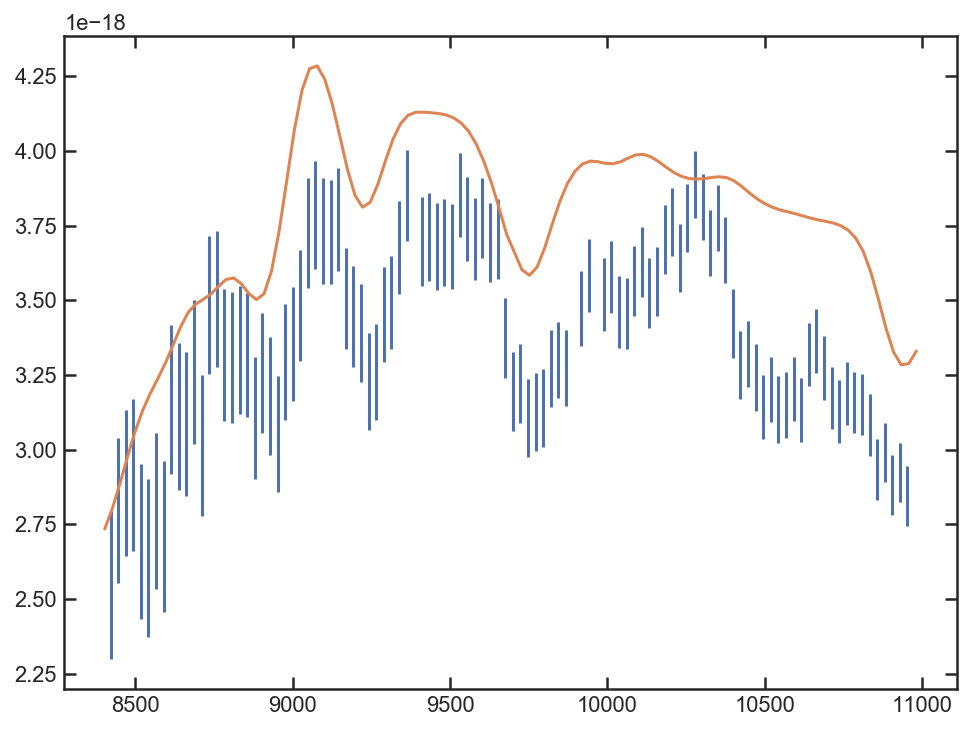

In [135]:
OFL = MFL - iIFL

plt.figure(figsize=[8,6])
plt.errorbar(MWV, MFL, MER, linestyle = 'none')
plt.plot(Cwm[IDW], Cfm[IDW]/ffl[IDW])

plt.figure(figsize=[8,6])
plt.errorbar(MWV, iIFL-OFL, iIER, linestyle = 'none')
plt.plot(Iwm[IDW], Ifm[IDW]/ffl[IDW]*1.6)

plt.figure(figsize=[8,6])
plt.errorbar(MWV, OFL, MER, linestyle = 'none')
plt.plot(Owm[IDW], Ofm[IDW]/ffl[IDW] / 2.3)

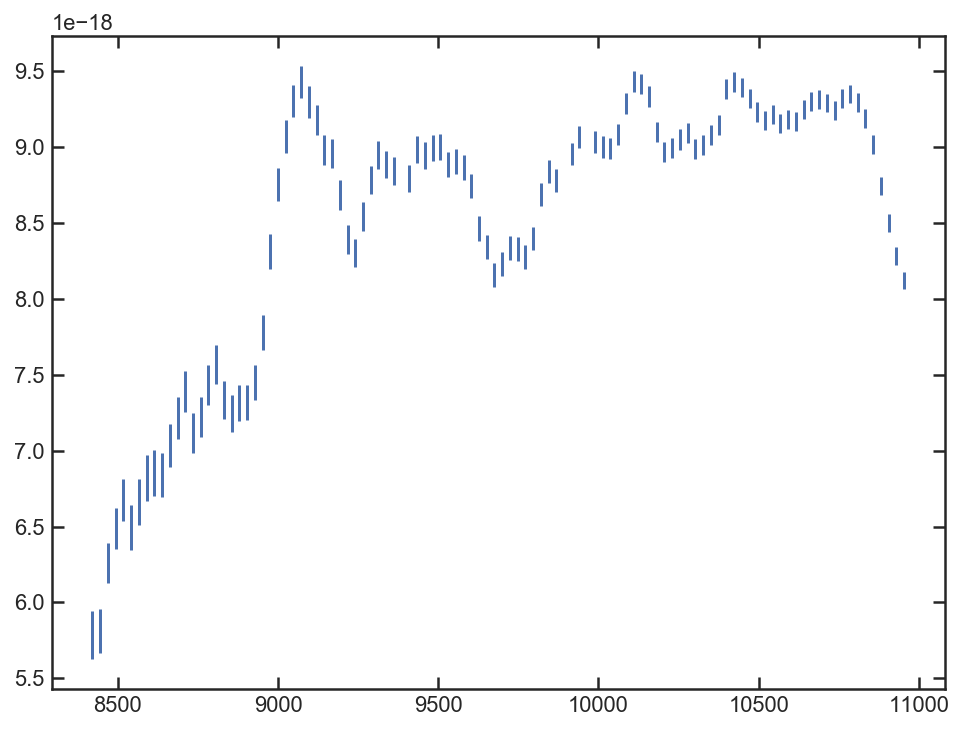

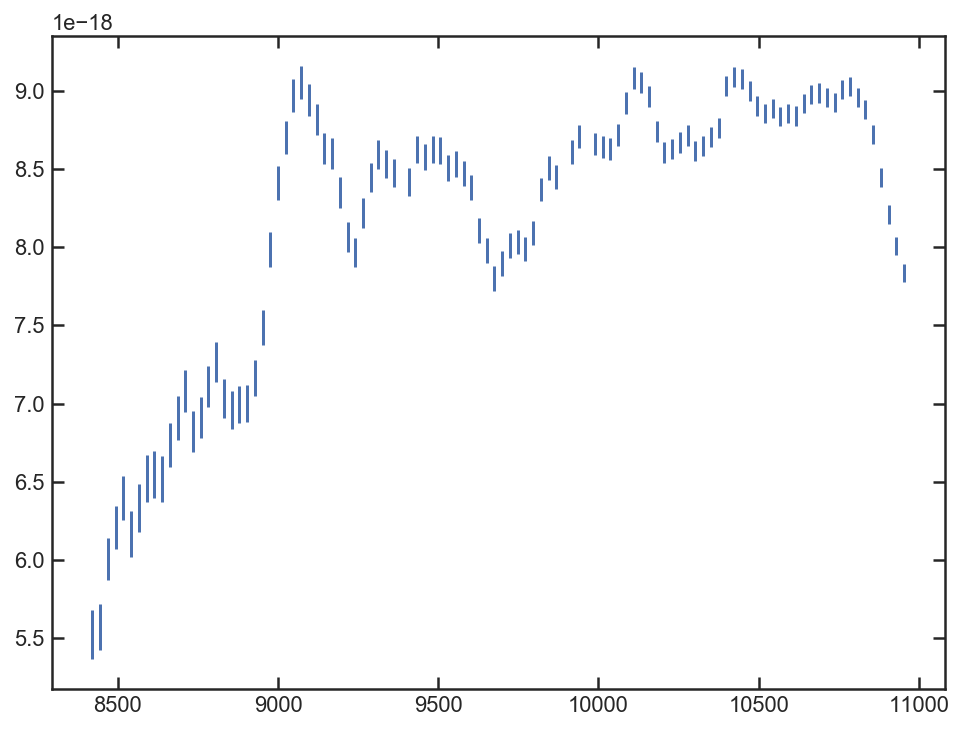

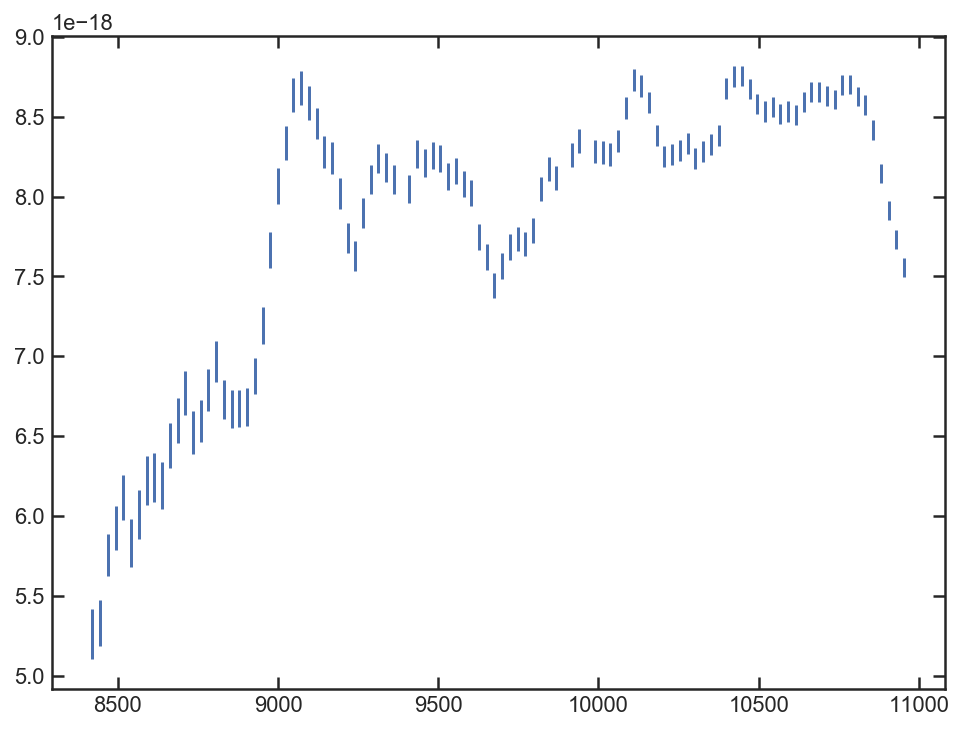

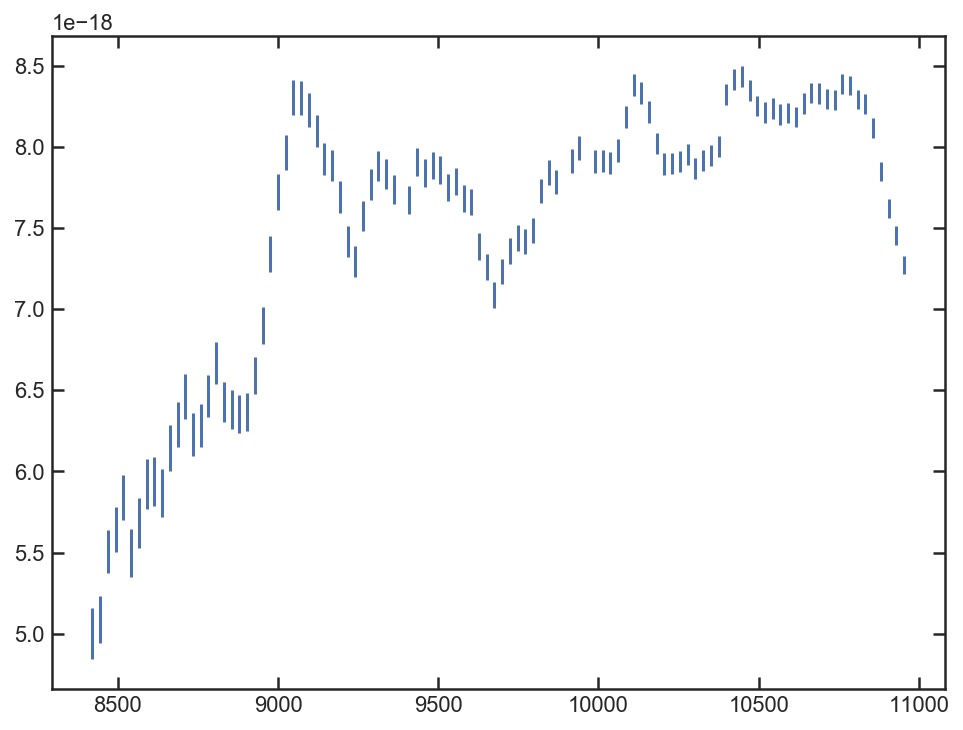

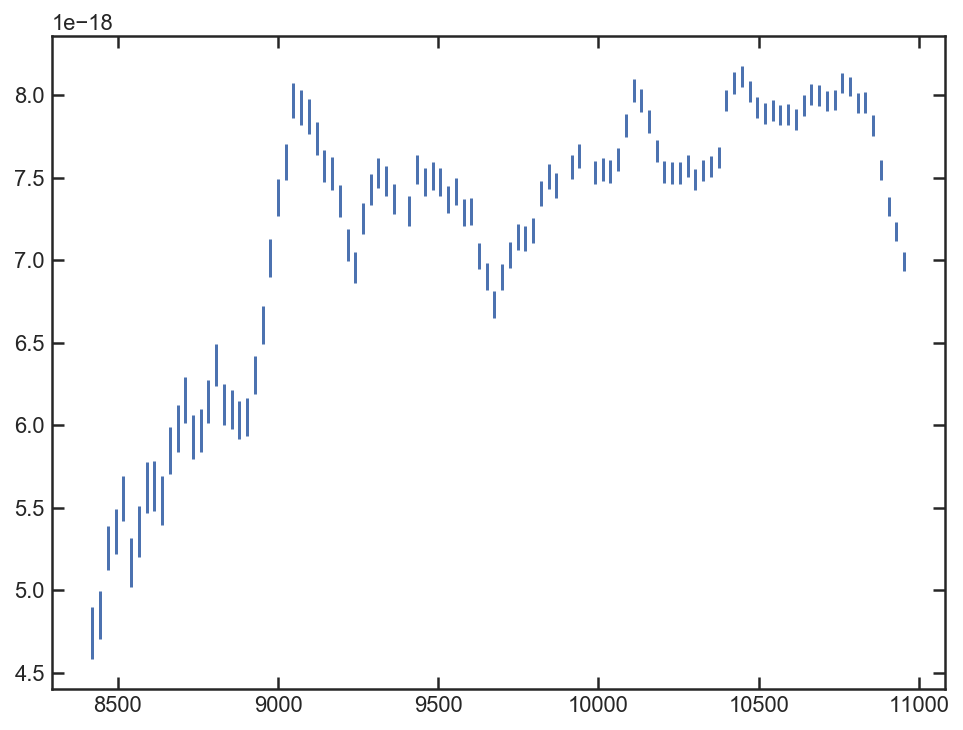

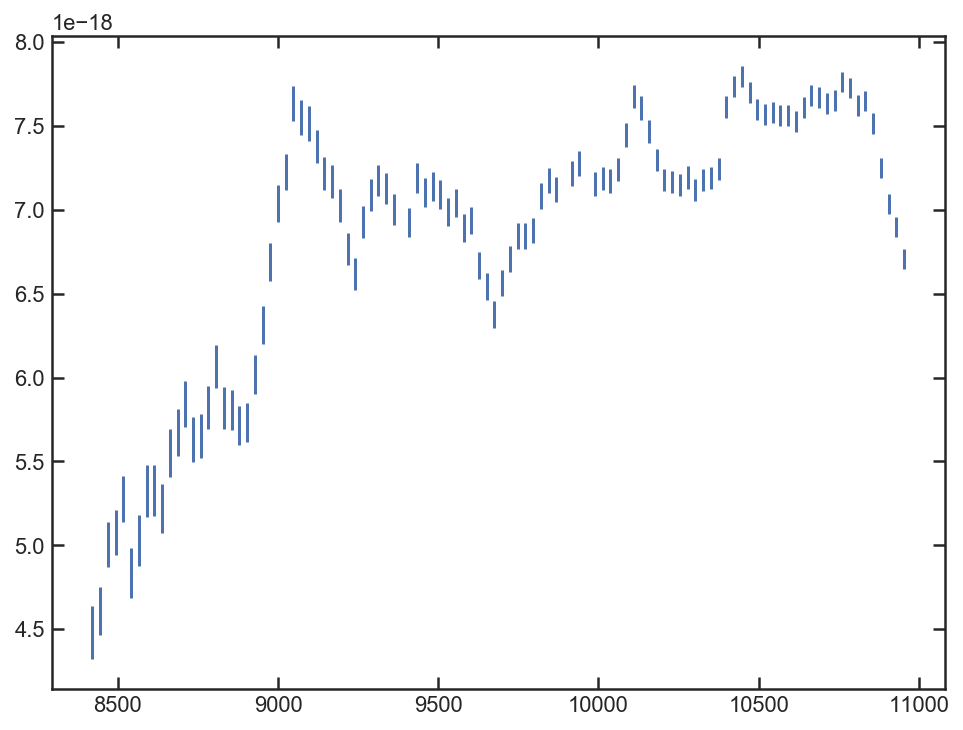

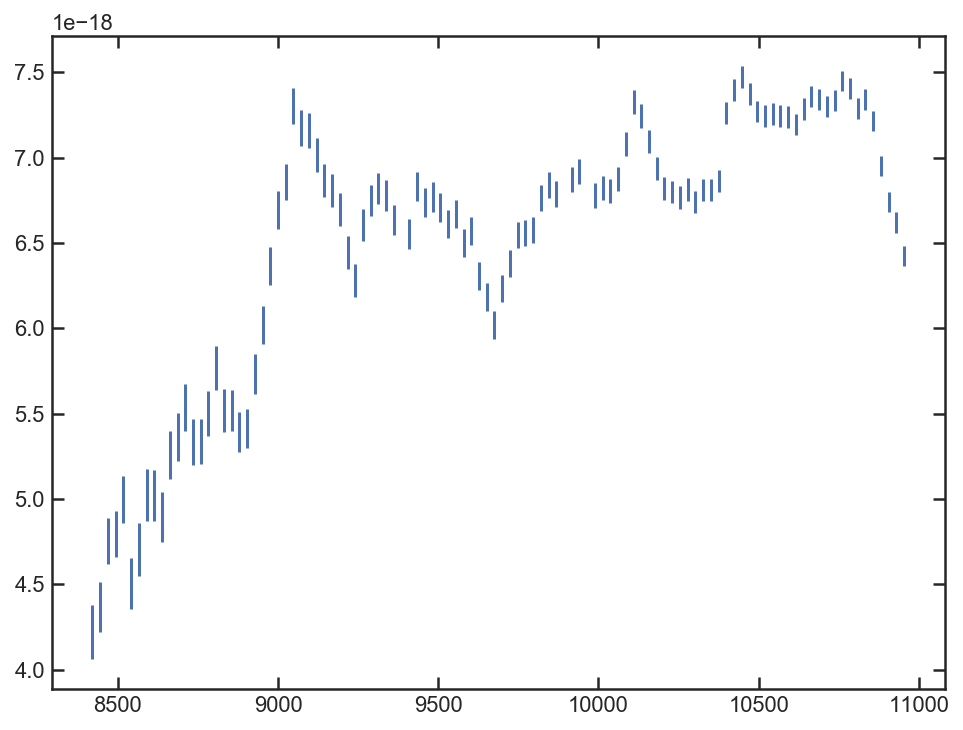

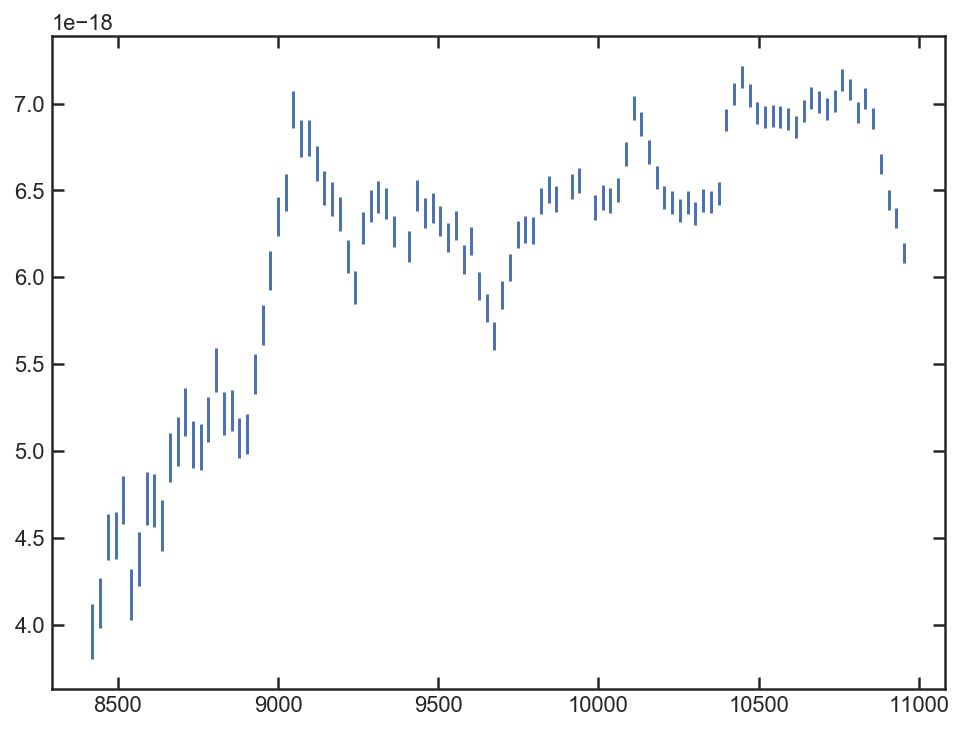

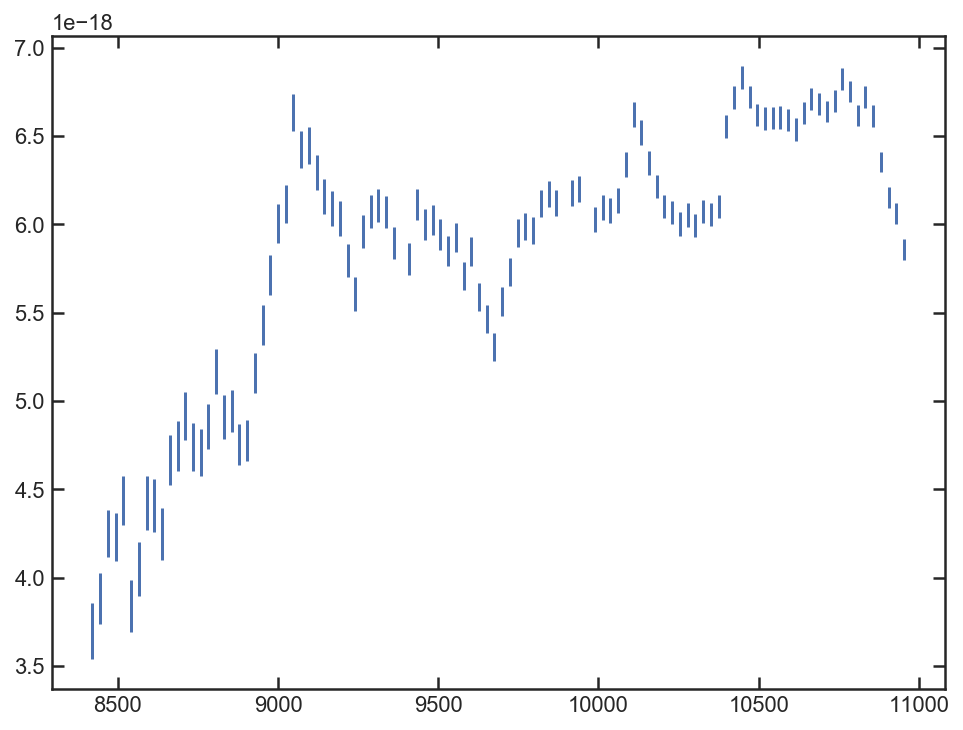

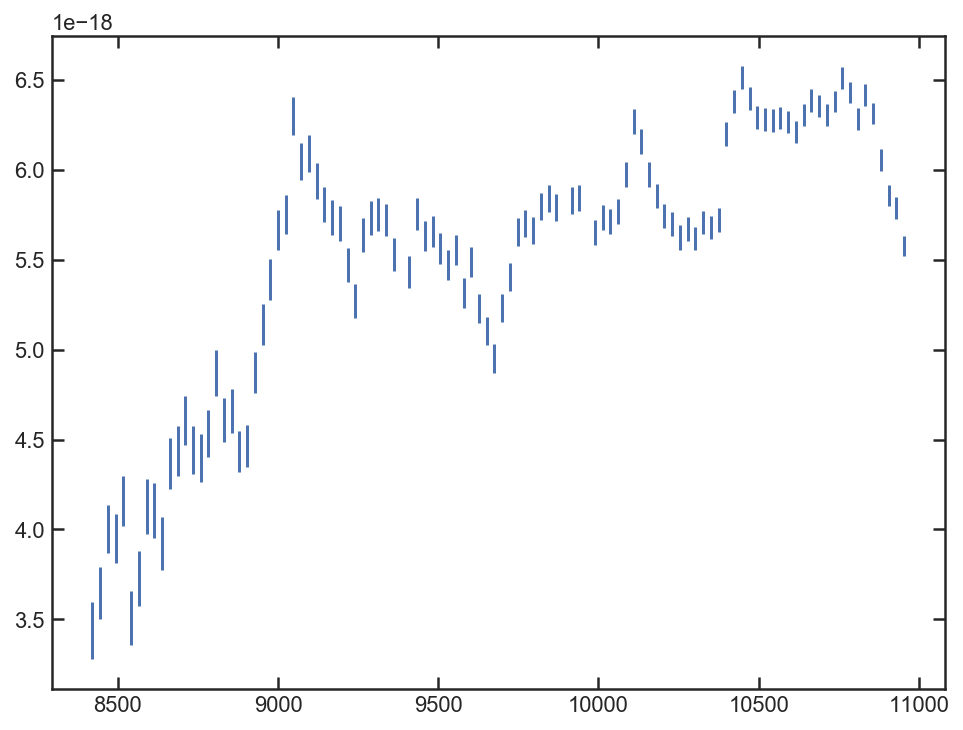

In [93]:

for i in range(10):
    plt.figure(figsize=[8,6])
    plt.errorbar(MWV, iIFL-OFL*0.1*i, iIER, linestyle = 'none')